## Import dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from PIL import Image
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import trange,tqdm

import pandas as pd

import copy
from collections import namedtuple
import os
import random
import shutil
import time

## Seed for reproducibility

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
#Path for UTKFace images
imgPath='dataset/'

## Custom Dataset

Biz custom dataset class yasaymiz

In [4]:
class UTKFaceDataset(data.Dataset):
    
    def __init__(self, csv_file, root_dir, transform):
        self.csv_file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, self.csv_file.iloc[idx, 0])
        
        image = Image.open(img_name).convert('RGB')
        label_age = self.csv_file.iloc[idx, 1]
        label_gender = self.csv_file.iloc[idx, 2]
        label_race = self.csv_file.iloc[idx, 3]
        
        if self.transform:
            image = self.transform(image)
            
        return {
            'image': image, 
            'label_age': label_age, 
            'label_gender': label_gender, 
            'label_race': label_race}

In [5]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize((pretrained_size, pretrained_size)),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize((pretrained_size, pretrained_size)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [6]:
train_dataset = UTKFaceDataset('train.csv', imgPath, train_transforms)

In [7]:
valid_dataset = UTKFaceDataset('valid.csv', imgPath, test_transforms)
test_dataset = UTKFaceDataset('test.csv', imgPath, test_transforms)

In [8]:
print(f'Number of train dataset: {len(train_dataset)}')
print(f'Number of valid dataset: {len(valid_dataset)}')
print(f'Number of test dataset: {len(test_dataset)}')

Number of train dataset: 16392
Number of valid dataset: 2893
Number of test dataset: 4821


In [9]:
BATCH_SIZE = 8

train_iterator = data.DataLoader(train_dataset, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_dataset, 
                                batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset, 
                                 batch_size = BATCH_SIZE)

In [10]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [11]:
def plot_images(images, labels, classes, normalize = True):
    
    n_images = len(images)
    
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    
    fig = plt.figure(figsize=(10,10))
    
    for i in range(rows*cols):
        
        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]
        
        if normalize:
            image = normalize_image(image)
            
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[int(labels[i])]
        ax.set_title(label)
        ax.axis('off')

In [12]:
classes_age = ['0-2', '3-6', '7-13', '14-20', '21-32', '33-43', '44-53', '54-']
classes_gender = ['male', 'female']
classes_race= ['White', 'Black', 'Asian', 'Indian', 'Others']

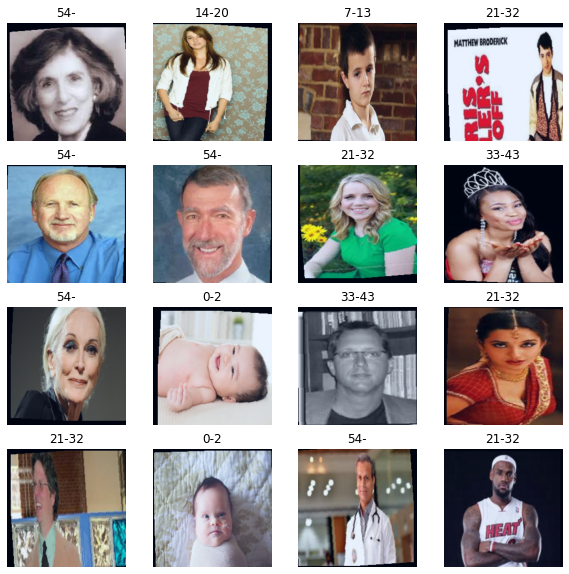

In [13]:
N_IMAGES = 20

images, labels = zip(*[(idx['image'], idx['label_age']) for idx in [train_dataset[i] for i in range(N_IMAGES)]])

plot_images(images, labels, classes_age)

## Create Custom Model

In [14]:
def weigths_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=1e-2)

In [15]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, 32, 3, stride=1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 64, 3, stride=1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 3, stride=1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, 3, stride=1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 384, 3, stride=1),
            nn.SELU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(384), 
            nn.AdaptiveMaxPool2d((5, 5))
        )
        
        self.fc_layer_age = nn.Sequential(
            nn.Linear(384*5*5, 512),
            nn.SELU(inplace=True),
            nn.AlphaDropout(0.5),
            nn.Linear(512, 512),
            nn.SELU(inplace=True),
            nn.AlphaDropout(0.5),
            nn.Linear(512, 8)
        )
        
        self.fc_layer_gender = nn.Sequential(
            nn.Linear(384*5*5, 512),
            nn.SELU(inplace=True),
            nn.AlphaDropout(0.5),
            nn.Linear(512, 512),
            nn.SELU(inplace=True),
            nn.AlphaDropout(0.5),
            nn.Linear(512, 2)
        )
        
        self.fc_layer_race = nn.Sequential(
            nn.Linear(384*5*5, 512),
            nn.SELU(inplace=True),
            nn.AlphaDropout(0.5),
            nn.Linear(512, 512),
            nn.SELU(inplace=True),
            nn.AlphaDropout(0.5),
            nn.Linear(512, 5)
        )
        
        self.apply(weigths_init)
        
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        label_age = self.fc_layer_age(x)
        label_gender = self.fc_layer_gender(x)
        label_race = self.fc_layer_race(x)
        
        return {'pred_age': label_age, 'pred_gender': label_gender, 'pred_race': label_race}
model = Net()

In [16]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model = model.to(device)

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]             448
              SELU-2         [-1, 16, 222, 222]               0
         MaxPool2d-3         [-1, 16, 111, 111]               0
       BatchNorm2d-4         [-1, 16, 111, 111]              32
            Conv2d-5         [-1, 32, 109, 109]           4,640
              SELU-6         [-1, 32, 109, 109]               0
         MaxPool2d-7           [-1, 32, 54, 54]               0
       BatchNorm2d-8           [-1, 32, 54, 54]              64
            Conv2d-9           [-1, 64, 52, 52]          18,496
             SELU-10           [-1, 64, 52, 52]               0
        MaxPool2d-11           [-1, 64, 26, 26]               0
      BatchNorm2d-12           [-1, 64, 26, 26]             128
           Conv2d-13          [-1, 128, 24, 24]          73,856
             SELU-14          [-1, 128,

## Model Training

### Loss and Optimizer defining

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 16,822,287 trainable parameters


In [18]:
# Loss Function
criterion = nn.CrossEntropyLoss().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3000], gamma=0.1)

In [19]:
# a function to calculate accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [20]:
def train(model, iterator, optimizer,  criterion, scheduler, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in tqdm(iterator, desc="Training", leave=False):
        
        image, label_age, label_gender, label_race = batch['image'].to(device), batch['label_age'], batch['label_gender'], batch['label_race']
        label_age = label_age.to(device)
        label_gender = label_gender.to(device)
        label_race = label_race.to(device)
        
#         label_age = torch.from_numpy(label_age.astype('long').to(device))
#         label_gender = torch.from_numpy(label_gender.astype('long').to(device))
#         label_race = torch.from_numpy(label_race.astype('long').to(device))
        
#         x = x.to(device)
#         y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(image)

        loss_age = criterion(y_pred['pred_age'], label_age.squeeze().long())
        loss_gender = criterion(y_pred['pred_gender'], label_gender.squeeze().long())
        loss_race = criterion(y_pred['pred_race'], label_race.squeeze().long())
        loss = loss_age + loss_gender + loss_race
        
        acc_age = calculate_accuracy(y_pred['pred_age'], label_age.squeeze().long())
        acc_gender = calculate_accuracy(y_pred['pred_gender'], label_gender.squeeze().long())
        acc_race = calculate_accuracy(y_pred['pred_race'], label_race.squeeze().long())
        acc = acc_age + acc_gender + acc_race

        loss.backward()

        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [21]:
def evaluate(model, iterator,  criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    
    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluation", leave=False): 
            image, label_age, label_gender, label_race = batch['image'].to(device), batch['label_age'], batch['label_gender'], batch['label_race']
            label_age = label_age.to(device)
            label_gender = label_gender.to(device)
            label_race = label_race.to(device)
        
#         label_age = torch.from_numpy(label_age.astype('long').to(device))
#         label_gender = torch.from_numpy(label_gender.astype('long').to(device))
#         label_race = torch.from_numpy(label_race.astype('long').to(device))
        
#         x = x.to(device)
#         y = y.to(device)

       

        y_pred = model(image)

        loss_age = criterion(y_pred['pred_age'], label_age.squeeze().long())
        loss_gender = criterion(y_pred['pred_gender'], label_gender.squeeze().long())
        loss_race = criterion(y_pred['pred_race'], label_race.squeeze().long())
        loss = loss_age + loss_gender + loss_race
        
        acc_age = calculate_accuracy(y_pred['pred_age'], label_age.squeeze().long())
        acc_gender = calculate_accuracy(y_pred['pred_gender'], label_gender.squeeze().long())
        acc_race = calculate_accuracy(y_pred['pred_race'], label_race.squeeze().long())
        acc = acc_age + acc_gender + acc_race

        #loss.backward()

        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
torch.set_grad_enabled(True)

In [24]:
EPOCHS = 5

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/2049 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 4m 24s
	Train Loss: 4.094 | Train Acc: 132.58%
	 Val. Loss: 0.013 |  Val. Acc: 0.17%


Training:   0%|          | 0/2049 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 4m 40s
	Train Loss: 3.894 | Train Acc: 142.42%
	 Val. Loss: 0.011 |  Val. Acc: 0.28%


Training:   0%|          | 0/2049 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 4m 44s
	Train Loss: 3.640 | Train Acc: 154.18%
	 Val. Loss: 0.009 |  Val. Acc: 0.33%


Training:   0%|          | 0/2049 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 4m 41s
	Train Loss: 3.565 | Train Acc: 157.75%
	 Val. Loss: 0.010 |  Val. Acc: 0.33%


Training:   0%|          | 0/2049 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/362 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 4m 47s
	Train Loss: 3.505 | Train Acc: 160.46%
	 Val. Loss: 0.010 |  Val. Acc: 0.44%


In [25]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluation:   0%|          | 0/603 [00:00<?, ?it/s]

Test Loss: 0.009 | Test Acc: 0.20%
